# Fake Review Detection

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import sqlite3
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## Load Data

In [3]:
conn = sqlite3.connect('../data/yelpResData.db')
conn.text_factory = lambda b: b.decode(errors = 'ignore')

In [4]:
# check table names in the database
res = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    print (name[0])

review
restaurant
reviewer


#### Load restaurant dataset

In [7]:
# load restaurant table to df
res = pd.read_sql("select * from restaurant;", conn)
res.columns

Index(['restaurantID', 'name', 'location', 'reviewCount', 'rating',
       'categories', 'address', 'Hours', 'GoodforKids', 'AcceptsCreditCards',
       'Parking', 'Attire', 'GoodforGroups', 'PriceRange', 'TakesReservations',
       'Delivery', 'Takeout', 'WaiterService', 'OutdoorSeating', 'WiFi',
       'GoodFor', 'Alcohol', 'NoiseLevel', 'Ambience', 'HasTV', 'Caters',
       'WheelchairAccessible', 'webSite', 'phoneNumber', 'filReviewCount'],
      dtype='object')

In [8]:
# take selection columns
columns = ['restaurantID', 'name', 'rating']
res = res[columns]

#### Load review dataset

In [9]:
# load review table to df
review = pd.read_sql("select * from review;", conn)
review.columns

Index(['date', 'reviewID', 'reviewerID', 'reviewContent', 'rating',
       'usefulCount', 'coolCount', 'funnyCount', 'flagged', 'restaurantID'],
      dtype='object')

In [11]:
# check the classes in flagged column
review.flagged.value_counts()

NR    402774
YR    318678
N      58716
Y       8303
Name: flagged, dtype: int64

There are 4 classes in the review dataframe. Y and N classes are not filtered by the Yelp fake review detection engine, less reliable labelling. Since we have about 700k reviews left (large enough) and the N and Y classes combined makes only 8.5% of the data, we decided to remove them, only keeping NR and YR classes.
- NR: True review
- YR: Fake review

In [12]:
review = review[(review.flagged != 'Y') & (review.flagged != 'N')]
review.reset_index(drop=True,inplace=True)

In [13]:
# checking if there are duplicated reviews
if (review.shape[0] == review.reviewID.nunique()):
    print('there are no duplicated reviews')
else:
    print('Duplicated reviews are')
    mask = review.duplicated(subset='reviewID', keep = False)
    review[mask]

there are no duplicated reviews


In [14]:
# clean the date column in review
mask = review.date.str.contains('Update')
ok_date = review[~mask]
notok_date = review[mask]
notok_date['date'] = notok_date['date'].apply(lambda x: str(x).split()[2])
review = pd.concat([ok_date, notok_date])

In [15]:
# convert date to datetime
review.date = pd.to_datetime(review.date)

#### Load reviewer dataset

In [16]:
# load reviewer table to df
reviewer = pd.read_sql("select * from reviewer;", conn)
reviewer.columns

Index(['reviewerID', 'name', 'location', 'yelpJoinDate', 'friendCount',
       'reviewCount', 'firstCount', 'usefulCount', 'coolCount', 'funnyCount',
       'complimentCount', 'tipCount', 'fanCount'],
      dtype='object')

In [17]:
# repeated columns in review and reviewer
review_reviewer_intersect = set(review.columns).intersection(set(reviewer.columns))
review_res_intersect = set(review.columns).intersection(set(res.columns))

print('review_reviewer_intersect: {}'.format(review_reviewer_intersect))
print('review_res_intersect: {}'.format(review_res_intersect))

review_reviewer_intersect: {'coolCount', 'funnyCount', 'usefulCount', 'reviewerID'}
review_res_intersect: {'rating', 'restaurantID'}


Both review and reviewer df have columns coolCount, funnyCount, usefulCount. We need to differentiate them. Similarly, review and restaurant both have rating columns

In [18]:
review = review.rename(columns={'coolCount':'review_coolCount', 'funnyCount':'review_funnyCount', 
                                'usefulCount':'review_usefulCount', 'rating': 'review_rating'})

In [19]:
# the yelpJoinDate is in format 'June 2019', change it to datetime object
reviewer['yelpJoinDate'] = reviewer['yelpJoinDate'].apply(lambda x: datetime.strftime(datetime.strptime(x, '%B %Y'), '01/%m/%Y'))
reviewer['yelpJoinDate'] = pd.to_datetime(reviewer['yelpJoinDate'])
reviewer['yelpJoinDate'].values[0]

numpy.datetime64('2009-01-10T00:00:00.000000000')

In [20]:
# merge the 3 tables
df_merged = review.merge(reviewer, on='reviewerID', how='inner')
df = df_merged.merge(res, on='restaurantID', how='inner')
print('Final df columns:')
print(df.columns.to_list())
df.head()

Final df columns:
['date', 'reviewID', 'reviewerID', 'reviewContent', 'review_rating', 'review_usefulCount', 'review_coolCount', 'review_funnyCount', 'flagged', 'restaurantID', 'name_x', 'location', 'yelpJoinDate', 'friendCount', 'reviewCount', 'firstCount', 'usefulCount', 'coolCount', 'funnyCount', 'complimentCount', 'tipCount', 'fanCount', 'name_y', 'rating']


,date,reviewID,reviewerID,reviewContent,review_rating,review_usefulCount,review_coolCount,review_funnyCount,flagged,restaurantID,...,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,name_y,rating
0,2012-09-25,xvdJntJlo01tHu83-vXiRw,bNYesZ944s6IJVowOnB0iA,Good choice by our Chicago friends for our fin...,4,0,0,0,NR,KU_Ze0TpR2HgKG2OpTh2NA,...,48,5,41,5,5,2,0,1,Slurping Turtle,3.5
1,2012-06-23,Z4oAUd6mIOhxxDsle3trPA,BSh3h1J4mdSmEsb8FFdf0Q,"I'm not a Takashi fan, so I was a bit hesitant...",4,0,0,0,YR,KU_Ze0TpR2HgKG2OpTh2NA,...,116,2,93,16,19,10,0,2,Slurping Turtle,3.5
2,2012-10-10,71c7BDude0l5tNjtxRZzMg,XVvbDeYn5Dk-MteNHwjC7Q,I should have read the the 3 stars and below r...,2,0,0,0,NR,KU_Ze0TpR2HgKG2OpTh2NA,...,14,1,5,1,3,0,4,1,Slurping Turtle,3.5
3,2011-12-15,Vrzm2xmm2aBqBRqs3yK9Zw,om5ZiponkpRqUNa3pVPiRg,It must be called slurping turtle because thei...,3,8,3,4,YR,KU_Ze0TpR2HgKG2OpTh2NA,...,2063,347,12660,9617,6682,6948,605,503,Slurping Turtle,3.5
4,2012-09-07,coKi6jCbVd4qSUpoE5_0iA,LZt80LbsfQ9kOz96H7c1bA,I'm surprised this place is getting so many ne...,4,2,2,1,NR,KU_Ze0TpR2HgKG2OpTh2NA,...,132,0,154,84,22,24,3,7,Slurping Turtle,3.5


In [5]:
# easy loading next time
#df.to_pickle('../data/merged_df.pkl')
df = pd.read_pickle('../data/merged_df.pkl')

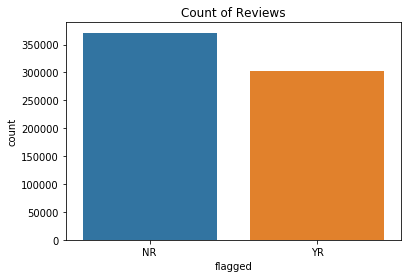

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='flagged', data=df)
plt.title("Count of Reviews")
plt.show()

In [1]:
print("hello")

hello


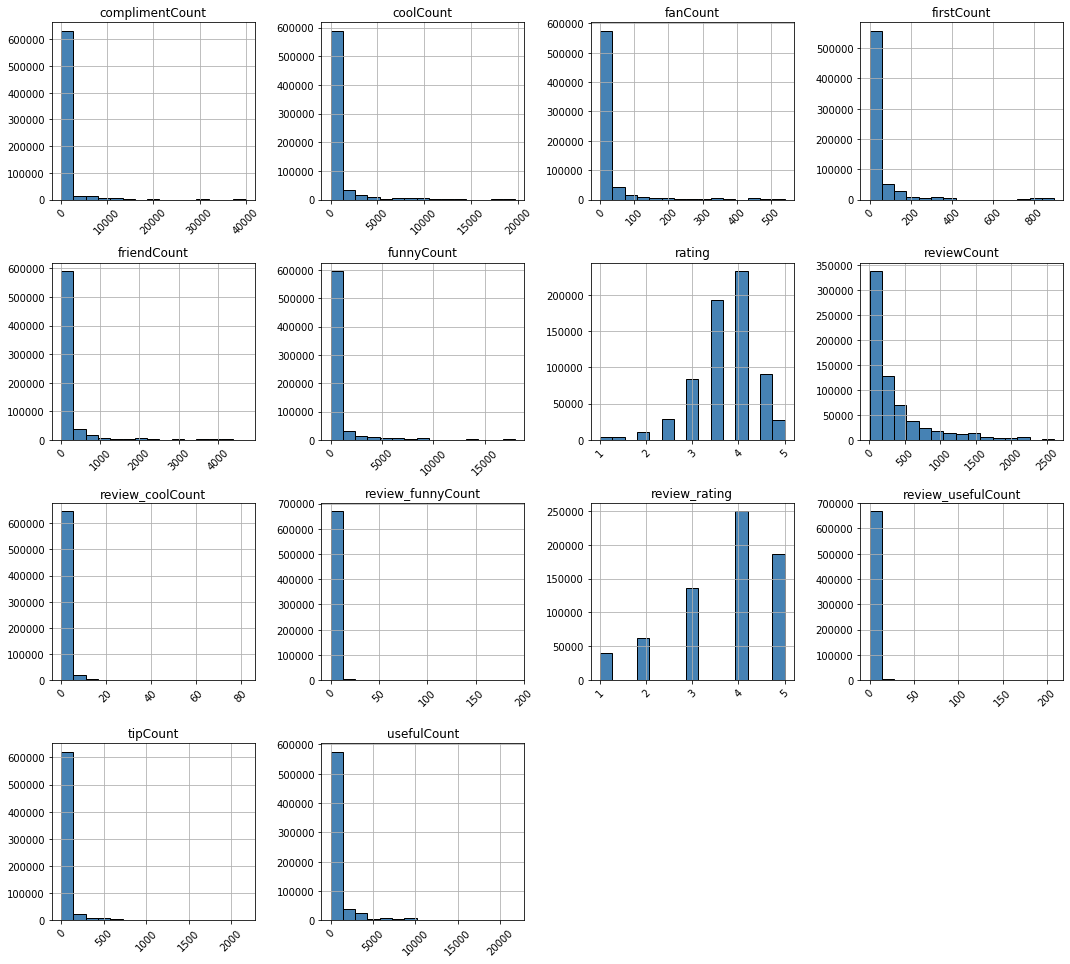

In [7]:
fig = df.hist(bins=15,
                 color='steelblue',
                 edgecolor='black', linewidth=1.0,
                 xlabelsize=10, ylabelsize=10,
                 xrot=45, yrot=0,
                 figsize=(10,9),
                 grid=True)

plt.tight_layout(rect=(0, 0, 1.5, 1.5))   

In [8]:
corr = df.corr()
corr

,review_rating,review_usefulCount,review_coolCount,review_funnyCount,friendCount,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,rating
review_rating,1.000000,-0.024263,0.074255,-0.045445,0.017090,-0.007511,0.013222,-0.000462,0.000930,-0.005237,-0.003356,-0.002211,0.009072,0.503092
review_usefulCount,-0.024263,1.000000,0.824246,0.694433,0.431367,0.306692,0.208935,0.499555,0.499179,0.496151,0.424757,0.294275,0.472292,0.008147
review_coolCount,0.074255,0.824246,1.000000,0.775390,0.480249,0.355731,0.235669,0.567755,0.574146,0.571171,0.485642,0.329947,0.536460,0.065627
review_funnyCount,-0.045445,0.694433,0.775390,1.000000,0.348317,0.252543,0.150458,0.428740,0.435259,0.458609,0.364980,0.259292,0.413211,-0.012127
friendCount,0.017090,0.431367,0.480249,0.348317,1.000000,0.606351,0.349458,0.809416,0.789352,0.741843,0.581343,0.554040,0.896678,0.013244
reviewCount,-0.007511,0.306692,0.355731,0.252543,0.606351,1.000000,0.669265,0.741942,0.704273,0.674705,0.476959,0.392337,0.675494,-0.007357
firstCount,0.013222,0.208935,0.235669,0.150458,0.349458,0.669265,1.000000,0.508797,0.482599,0.423510,0.391282,0.206795,0.394679,-0.017568
usefulCount,-0.000462,0.499555,0.567755,0.428740,0.809416,0.741942,0.508797,1.000000,0.994914,0.974957,0.791283,0.623442,0.908754,0.004193
coolCount,0.000930,0.499179,0.574146,0.435259,0.789352,0.704273,0.482599,0.994914,1.000000,0.981694,0.795849,0.620783,0.901314,0.005212
funnyCount,-0.005237,0.496151,0.571171,0.458609,0.741843,0.674705,0.423510,0.974957,0.981694,1.000000,0.764591,0.640476,0.888493,0.003412


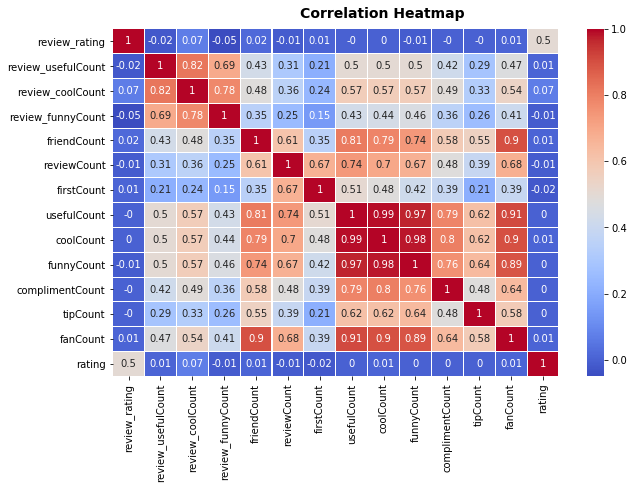

In [9]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

hm = sns.heatmap(round(corr,2), 
                 ax=ax,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 cmap="coolwarm", # Color Map.
                 #square=True,    # If True, set the Axes aspect to “equal” so each cell will be square-shaped.
                 annot=True, 
                 #annot_kws={"size": 14},
                 linewidths=.05)

fig.subplots_adjust(top=0.93)

t = fig.suptitle('Correlation Heatmap', fontsize=14, fontweight='bold')

(673659, 24)
(302317, 24)
(371342, 24)


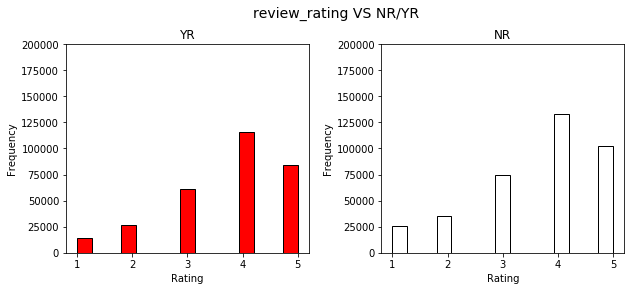

In [10]:
fig = plt.figure(figsize = (10,4))
title = fig.suptitle("review_rating VS NR/YR", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2, 1)
ax1.set_title("YR")
ax1.set_xlabel("Rating")
ax1.set_ylabel("Frequency") 
ax1.set_ylim([0, 200000])
#ax1.text(1.2, 800, r'$\mu$='+str(round(df['sulphates'].mean(),2)),  fontsize=12)
YR_data = df[df['flagged'] ==  'YR']
print(df.shape)
print(YR_data.shape)
r_freq, r_bins, r_patches = ax1.hist(YR_data['review_rating'], color='red', bins=15,
                                     edgecolor='black', linewidth=1)

ax2 = fig.add_subplot(1,2, 2)
ax2.set_title("NR")
ax2.set_xlabel("Rating")
ax2.set_ylabel("Frequency")
ax2.set_ylim([0, 200000])
#ax2.text(0.8, 800, r'$\mu$='+str(round(white_wine['sulphates'].mean(),2)),    fontsize=12)
NR_data = df[df['flagged'] ==  'NR']
print(NR_data.shape)
w_freq, w_bins, w_patches = ax2.hist(NR_data['review_rating'], color='white', bins=15,
                                     edgecolor='black', linewidth=1)

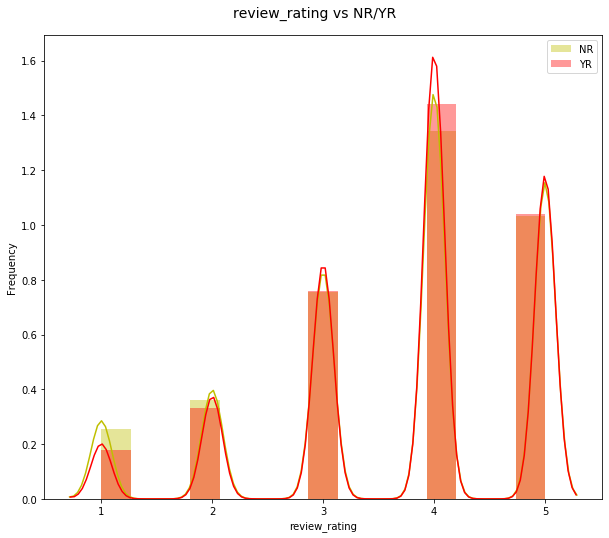

In [11]:
fig = plt.figure(figsize = (10, 8))
title = fig.suptitle("review_rating vs NR/YR", fontsize=14)
fig.subplots_adjust(top=0.93, wspace=0.3)

ax = fig.add_subplot(1,1,1)
ax.set_xlabel("Sulphates")
ax.set_ylabel("Frequency") 

g = sns.FacetGrid(df, hue='flagged', palette={"YR": "r", "NR": "y"})
g.map(sns.distplot, 'review_rating', kde=True, bins=15, ax=ax)
ax.legend(title='')
plt.close(2)

(673659, 24)
(302317, 24)
(371342, 24)


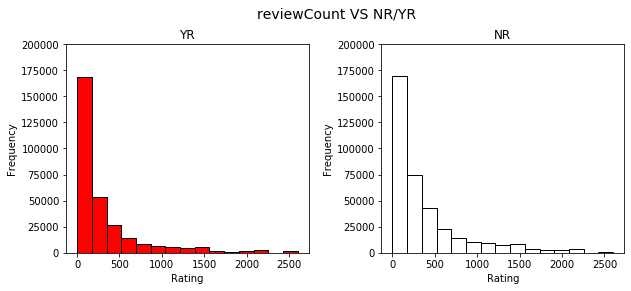

In [12]:
fig = plt.figure(figsize = (10,4))
title = fig.suptitle("reviewCount VS NR/YR", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2, 1)
ax1.set_title("YR")
ax1.set_xlabel("Rating")
ax1.set_ylabel("Frequency") 
ax1.set_ylim([0, 200000])
#ax1.text(1.2, 800, r'$\mu$='+str(round(df['sulphates'].mean(),2)),  fontsize=12)
YR_data = df[df['flagged'] ==  'YR']
print(df.shape)
print(YR_data.shape)
r_freq, r_bins, r_patches = ax1.hist(YR_data['reviewCount'], color='red', bins=15,
                                     edgecolor='black', linewidth=1)

ax2 = fig.add_subplot(1,2, 2)
ax2.set_title("NR")
ax2.set_xlabel("Rating")
ax2.set_ylabel("Frequency")
ax2.set_ylim([0, 200000])
#ax2.text(0.8, 800, r'$\mu$='+str(round(white_wine['sulphates'].mean(),2)),    fontsize=12)
NR_data = df[df['flagged'] ==  'NR']
print(NR_data.shape)
w_freq, w_bins, w_patches = ax2.hist(NR_data['reviewCount'], color='white', bins=15,
                                     edgecolor='black', linewidth=1)

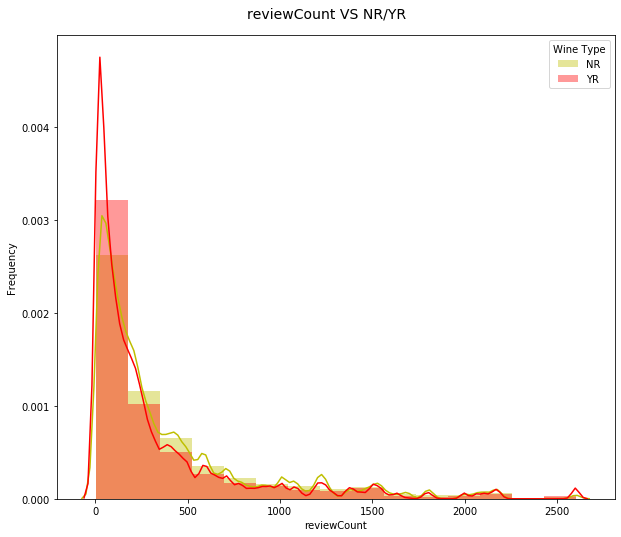

In [13]:
fig = plt.figure(figsize = (10, 8))
title = fig.suptitle("reviewCount VS NR/YR", fontsize=14)
fig.subplots_adjust(top=0.93, wspace=0.3)

ax = fig.add_subplot(1,1,1)
ax.set_xlabel("Sulphates")
ax.set_ylabel("Frequency") 

g = sns.FacetGrid(df, hue='flagged', palette={"YR": "r", "NR": "y"})
g.map(sns.distplot, 'reviewCount', kde=True, bins=15, ax=ax)
ax.legend(title='Wine Type')
plt.close(2)